# Importação das bibliotecas necessárias

In [1974]:
import joblib
import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from unidecode import unidecode

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
from skopt import BayesSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import lime
import lime.lime_tabular

# Criação de dataset

In [1862]:
df = pd.read_feather('../data/carteira_total.feather')


In [1863]:
df.head(3)

mÊs    ID CRM  ID NAVPLAT      ID SAP REGIÃO      CIDADE      BAIRRO  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   VALOR MENSAL  VALOR HOJE UPSALE/DOWNSALE  ...  LEADS FORM LEADS VER DATO  \
0         434.4       434.4              ok  ...        21.0          100.0   
1         312.0       312.0              ok  ...        18.0          106.0   
2        1798.8      1798.8              ok  ...       174.0          520.0   

  LEADS TOTAL Custo por lead total  Total Contratado  TOTAL DE LISTINGS  \
0       121.0             3.590083              50.0                  9   
1       124.0             2.516129              25.0                  7   
2       694.0             2.591931           10031.0                 67   

   CUSTO POR LISTING  PF/PJ  Total Utilizado  Faixa Listings  
0          48.266667     PJ              9.0          6 – 10  
1          44.571429     PF              7.0          6 – 10  
2          26.847761     PJ             67.0        61 – 100  

[3 rows x 36 columns]

# Pandas Proffling

In [1864]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [1865]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica


# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [1866]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [1867]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)
df['churn'] = df['churn'].astype(int)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [1868]:
df.head(3)

mes    id_crm  id_navplat      id_sap regiao      cidade      bairro  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   valor_mensal  valor_hoje  faturamento  ... leads_ver_dato leads_total  \
0         434.4       434.4        434.0  ...          100.0       121.0   
1         312.0       312.0        312.0  ...          106.0       124.0   
2        1798.8      1798.8       1799.0  ...          520.0       694.0   

  custo_por_lead_total  total_contratado  total_de_listings  \
0             3.590083              50.0                  9   
1             2.516129              25.0                  7   
2             2.591931           10031.0                 67   

   custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  
0          48.266667     PJ              9.0          6 – 10      0  
1          44.571429     PF              7.0          6 – 10      0  
2          26.847761     PJ             67.0        61 – 100      0  

[3 rows x 36 columns]

#### Adição da coluna quantidade_mes respectiva a quantidade de meses os ID SAP é cliente

In [1869]:
df_grouped = df[['mes', 'id_sap']].groupby(['id_sap']).count().reset_index()

df_grouped.rename(columns = {'mes':'quantidade_mes'}, inplace=True)

In [1870]:
df_grouped.sample(2)


id_sap  quantidade_mes
15988  2003456438               2
8534   2000500164              22

In [1871]:
df = df.join(df_grouped.set_index('id_sap'), on='id_sap')
    

In [1872]:
df.sample(2)

mes    id_crm  id_navplat      id_sap regiao       cidade  \
38757 2020-07-01  47097513    47043414  2000337256     SP  SÃO VICENTE   
90784 2021-03-01  47337347    47337348  2000613309     PR     CURITIBA   

             bairro  valor_mensal  valor_hoje  faturamento  ... leads_total  \
38757  Vila Valença         358.8       358.8        359.0  ...       170.0   
90784             0         579.0       579.0        579.0  ...        96.0   

      custo_por_lead_total total_contratado  total_de_listings  \
38757             2.110588          10018.0               1926   
90784             6.031250              0.0                  0   

       custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  \
38757           0.186293     PJ           1926.0     1001 – 2000      0   
90784           0.000000     PJ              9.0          6 – 10      0   

       quantidade_mes  
38757              22  
90784              17  

[2 rows x 37 columns]

#### Definição do quality score de cada registro

In [1873]:
xls = pd.ExcelFile('../data/quality_score.xlsx')
xls.sheet_names

i = 0
for data in xls.sheet_names:
    if i == 0:
        dfQuality = pd.read_excel(xls, data)
        dfQuality['data'] = data
        dfQuality.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                  'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)
    else:
        dfQualityAux = pd.read_excel(xls, data)
        dfQualityAux['data'] = data
        dfQualityAux.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                     'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)

        dfQuality = pd.concat([dfQuality, dfQualityAux])

    i+=1

In [1874]:
dfQuality['status_pagamento'].unique()


array(['4. Péssimo', '2. Regular ', '1. Bom', '3. Ruim', '5. Novo', 'C2C',
       '2. Regular', '1. Bom ', 'lançamentos', nan, '5. novo', 0],
      dtype=object)

In [1875]:
dfQuality['status_pagamento'].replace({'4. Péssimo': 'Pessimo', '2. Regular ': 'Regular', '1. Bom': 'Bom', '3. Ruim': 'Ruim', '5. Novo': 'Novo',
                                       '2. Regular': 'Regular', '1. Bom ': 'Bom', 'lançamentos': np.nan, '5. novo': 'Novo', 0: np.nan}, inplace=True)


In [1876]:
dfQuality.head()


ID SAP status_pagamento   data
0  2000252554          Pessimo  out20
1  2000251191          Regular  out20
2  2000251824              Bom  out20
3  2000248936              Bom  out20
4  2000252090              Bom  out20

In [1877]:
dfQuality.dropna(inplace=True)

In [1878]:
dfQuality['status_pagamento'].isna().sum()


0

In [1879]:
regex = r'([0-9]{4})-([0-9]{2})-[0-9]{2}'

def fun_replace(data): 
    return datetime.datetime.strptime(str(data.group(2)).lower(), '%m').strftime('%b').lower() + data.group(1)[-2:]

df['mes'] = df['mes'].astype(str).str.replace(regex, fun_replace, regex=True)


In [1880]:
dfQuality.columns


Index(['ID SAP', 'status_pagamento', 'data'], dtype='object')

In [1881]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes'],
      dtype='object')

In [1882]:
dfQuality.rename(columns={'ID SAP': 'id_sap', 'data' : 'mes'}, inplace=True)

In [1883]:
df = df.join(dfQuality.set_index(['id_sap', 'mes']), on=['id_sap', 'mes'])


## Padronizando valores categóricos

### Oficina

In [1884]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [1885]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

### Faturamento

In [1886]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', '0'], dtype=object)

In [1887]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [1888]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [1889]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

### Tipo de Plano

In [1890]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', 'nan', 'SIMPLES', 'PACK', '0'],
      dtype=object)

### Midia Ativa

In [1891]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', None], dtype=object)

### PF_PJ

In [1892]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

### Equipe

In [1893]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [1894]:
# Alterando para valores ficarem iguais
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)
df['equipe'].unique()

array(['REGIONAL DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias'],
      dtype=object)

In [1895]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes', 'status_pagamento'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [1896]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Analise Grafica

### Análise região (não aparenta influenciar no churn)

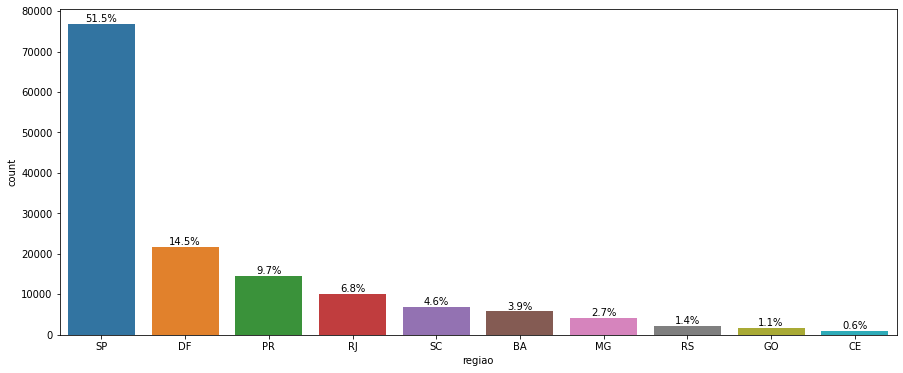

In [1897]:
serie_filtrada = df["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

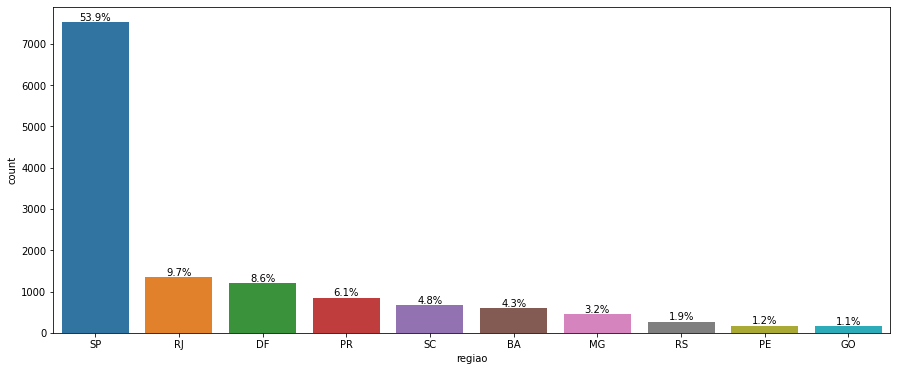

In [1898]:
serie_filtrada = df[df["churn"] == 1]["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Cidade (não aparenta influenciar no churn)

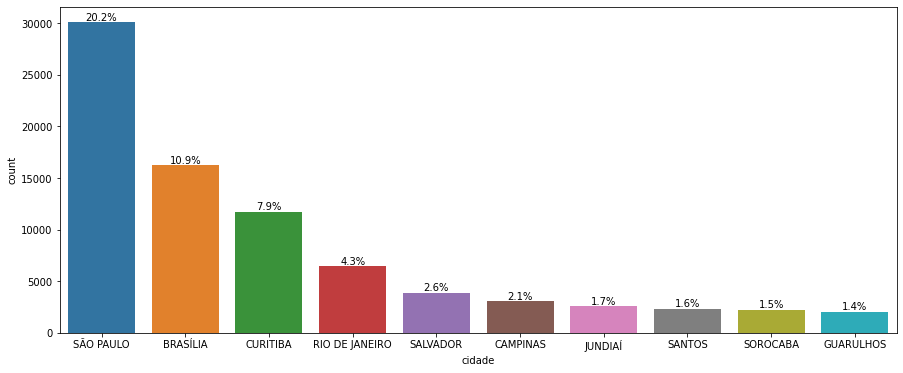

In [1899]:
serie_filtrada = df["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

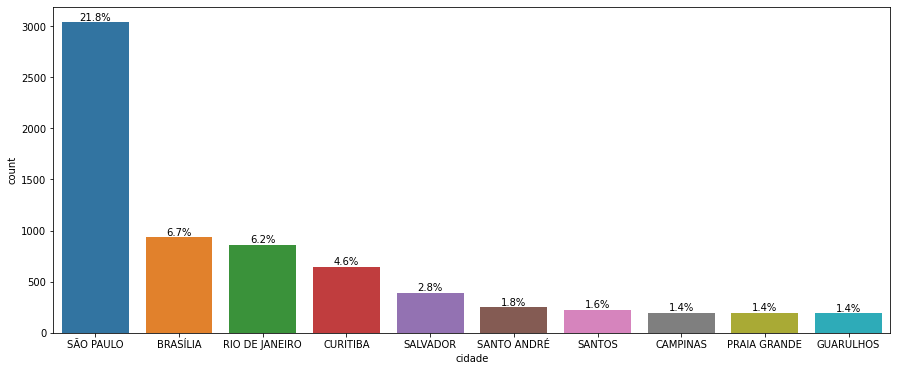

In [1900]:
serie_filtrada = df[df["churn"] == 1]["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Oficina (não aparenta influenciar no churn)

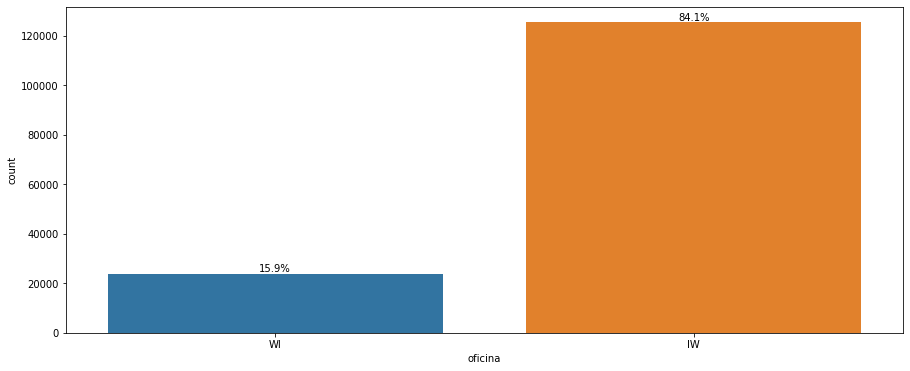

In [1901]:
serie_filtrada = df["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

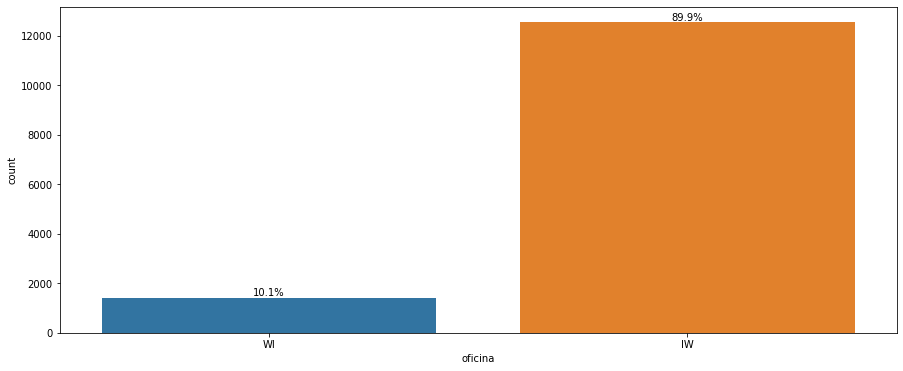

In [1902]:
serie_filtrada = df[df["churn"] == 1]["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Frequência Faturamento (não aparenta influenciar no churn)

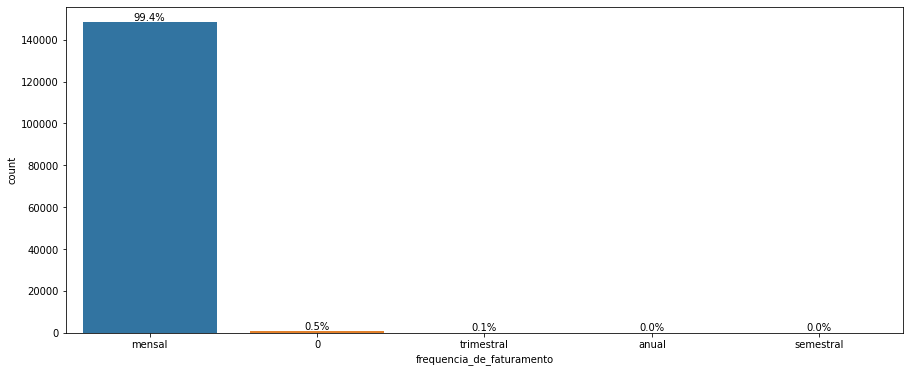

In [1903]:
serie_filtrada = df["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

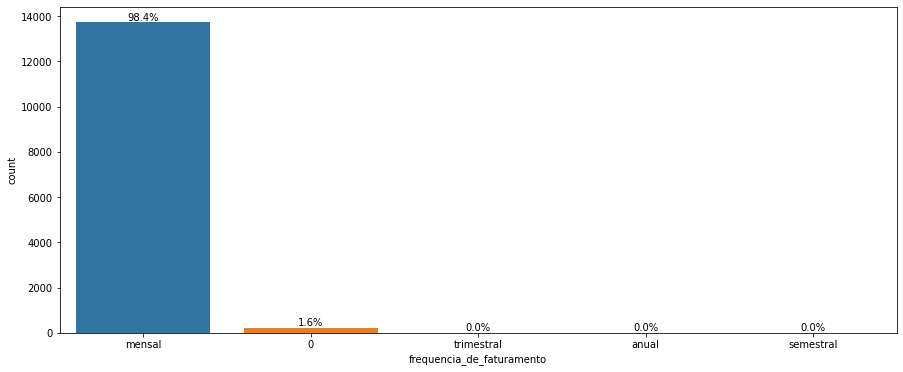

In [1904]:
serie_filtrada = df[df["churn"] == 1]["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Tipo de Plano (pode influenciar no churn)

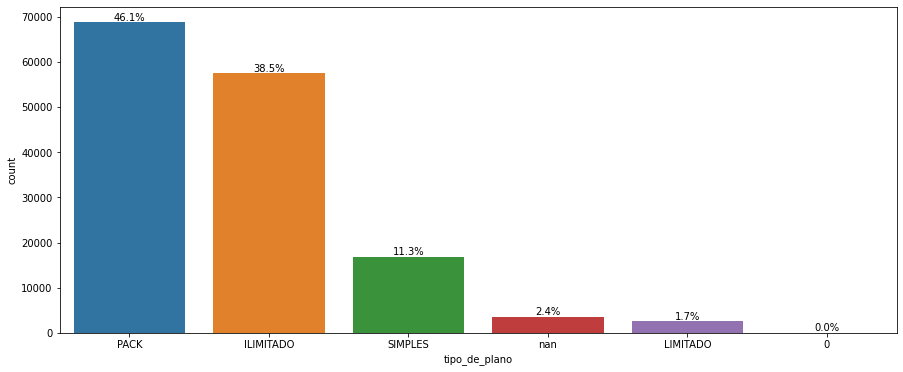

In [1905]:
serie_filtrada = df["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

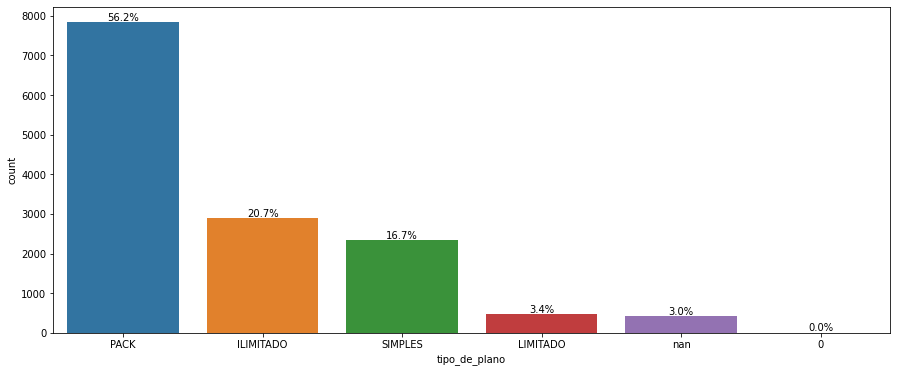

In [1906]:
serie_filtrada = df[df["churn"] == 1]["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Executivo Carteira Atual (não aparenta influenciar no churn)

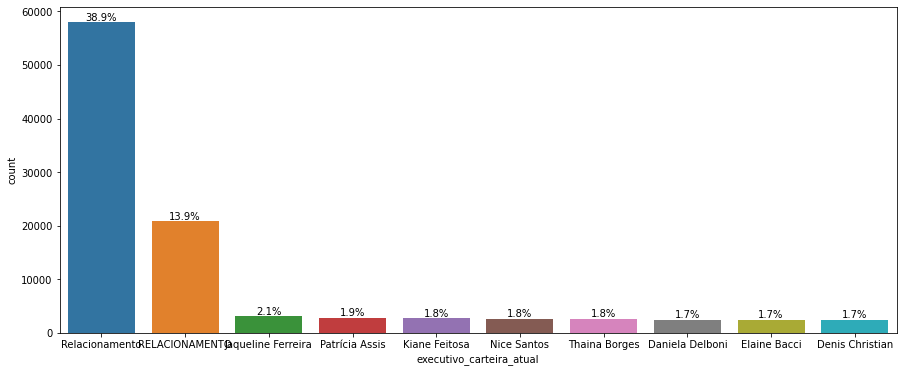

In [1907]:
serie_filtrada = df["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

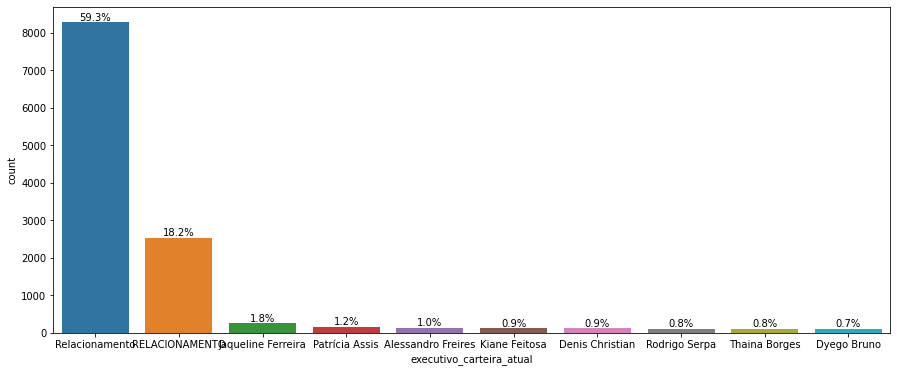

In [1908]:
serie_filtrada = df[df["churn"] == 1]["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Equipe (pode influenciar no churn)

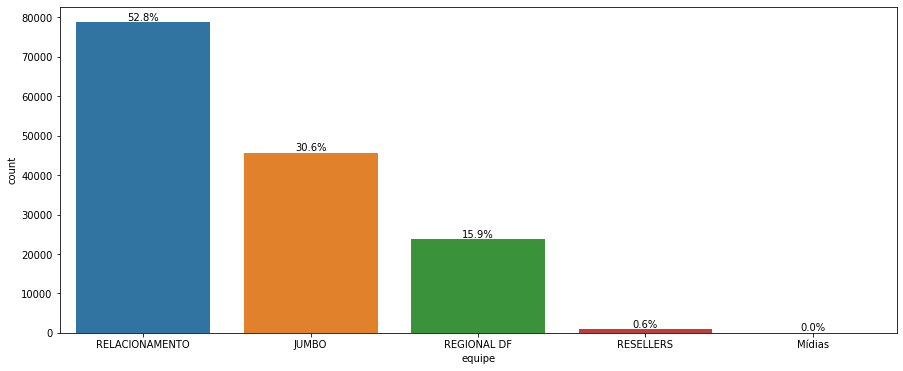

In [1909]:
serie_filtrada = df["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

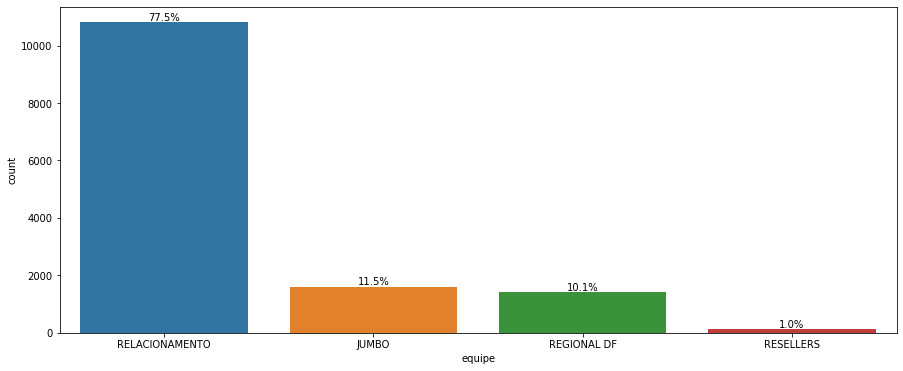

In [1910]:
serie_filtrada = df[df["churn"] == 1]["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Status Final (alta correlação com churn, talvez não seja interessante manter)

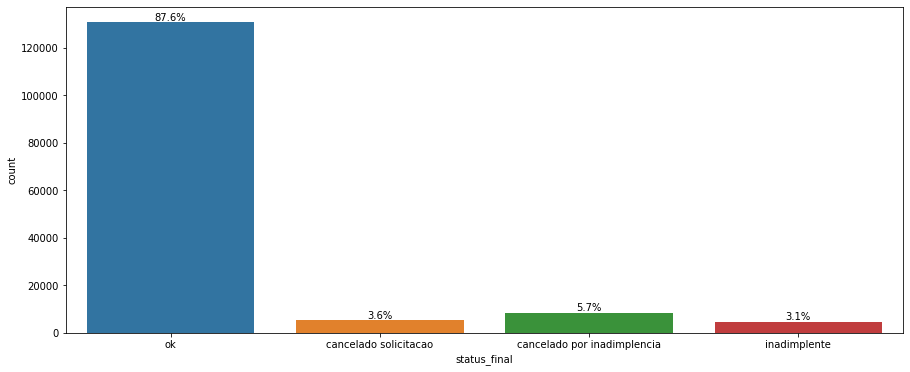

In [1911]:
serie_filtrada = df["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

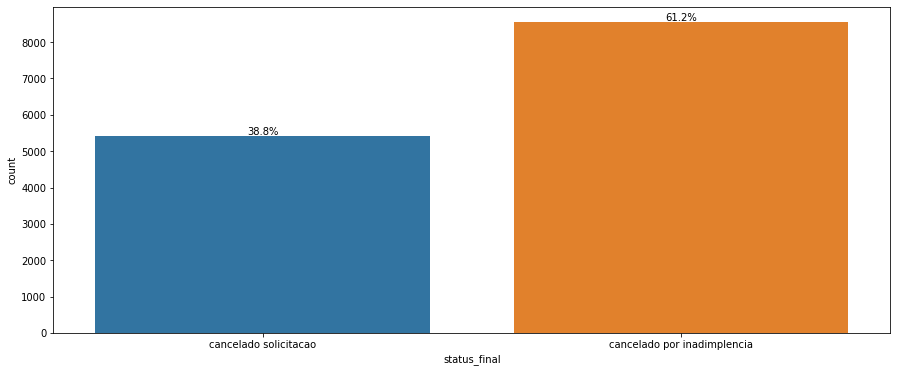

In [1912]:
serie_filtrada = df[df["churn"] == 1]["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Possui Midia Ativa (pode ter influencia no churn, mas muito pouco)

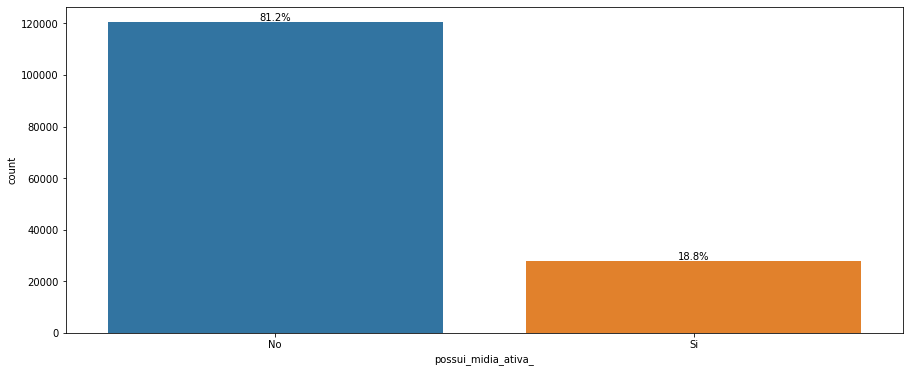

In [1913]:
serie_filtrada = df["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

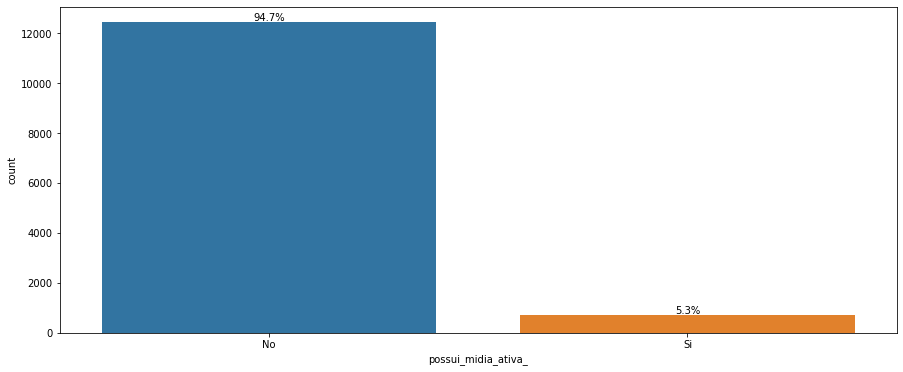

In [1914]:
serie_filtrada = df[df["churn"] == 1]["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Pessoa Física Jurídica (relação forte com o churn)

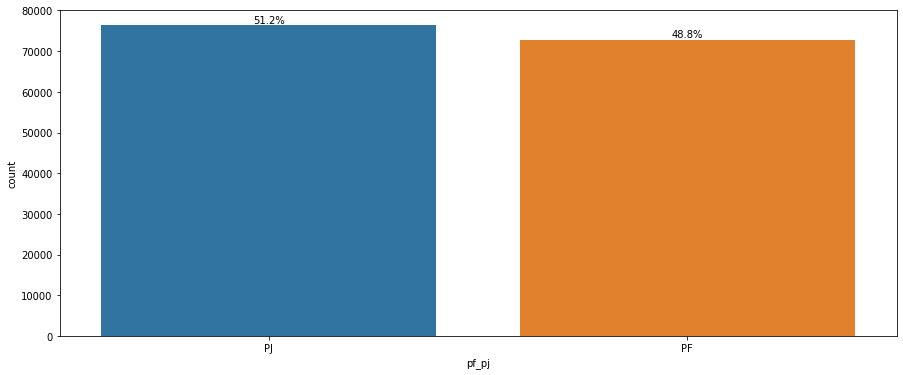

In [1915]:
serie_filtrada = df["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

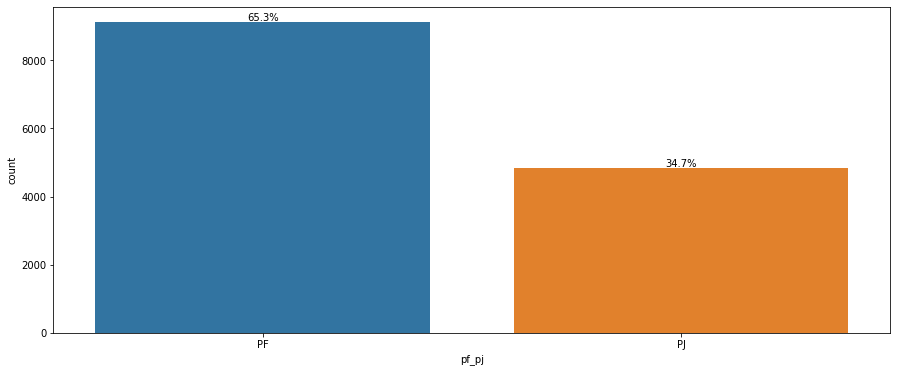

In [1916]:
serie_filtrada = df[df["churn"] == 1]["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Faixa Listings (relação forte com o churn)

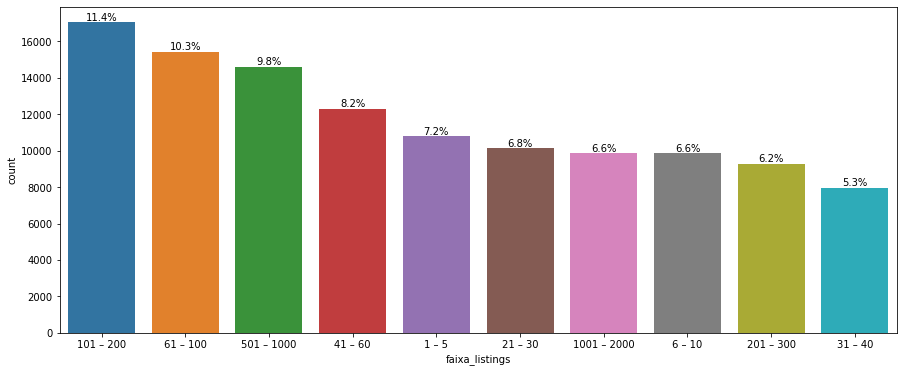

In [1917]:
serie_filtrada = df["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

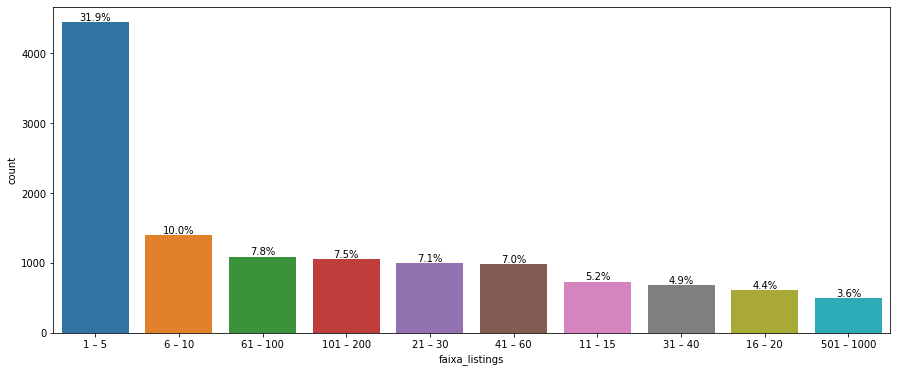

In [1918]:
serie_filtrada = df[df["churn"] == 1]["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

In [1919]:
def box_plot(coluna_medida, limite_inferior, limite_superior):
    f, ax = plt.subplots(figsize=(5, 4))
    sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
    plt.ylim((limite_inferior, limite_superior))
    sns.stripplot(x="churn", y=coluna_medida, data=df,
                size=1, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel=coluna_medida)
    sns.despine(trim=True, left=True)

### Análise Valor Mensal (pode influenciar no churn, mas pouco)

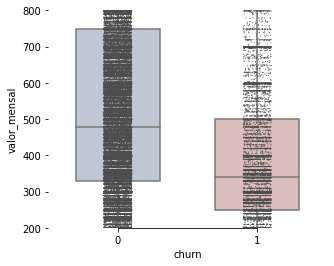

In [1920]:
box_plot("valor_mensal", 200, 800)

### Análise Valor Hoje (alta correlação com churn. Talvez seja melhor remover)

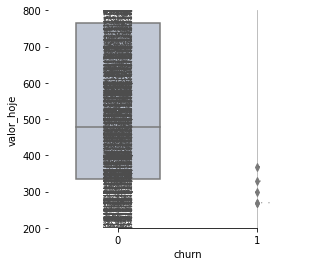

In [1921]:
box_plot("valor_hoje", 200, 800)

### Análise Faturamento (Alta correlação com churn. Talvez seja melhor tirar)

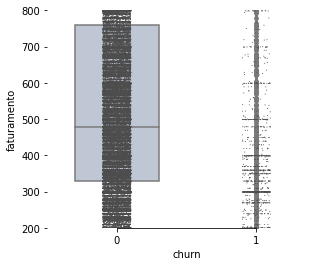

In [1922]:
box_plot("faturamento", 200, 800)

### Análise Contratado Super Destaques (pode influenciar no churn)

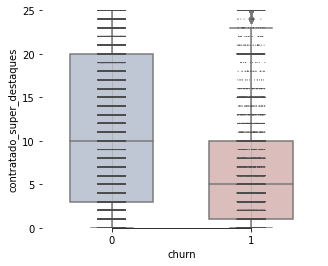

In [1923]:
box_plot("contratado_super_destaques", 0, 25)

### Análise Contratado Destaques (não aparenta influenciar no churn)

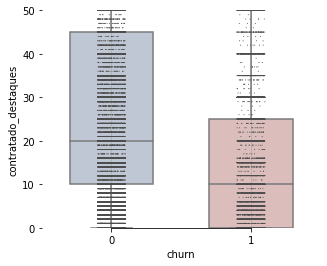

In [1924]:
box_plot("contratado_destaques", 0, 50)

### Análise Contratado Ofertas Simples (Relação forte com o churn)

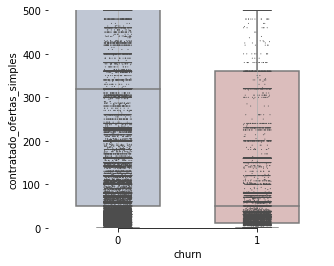

In [1925]:
box_plot("contratado_ofertas_simples", 0, 500)

### Análise Utilizado Super Destaque (pode influenciar o churn)

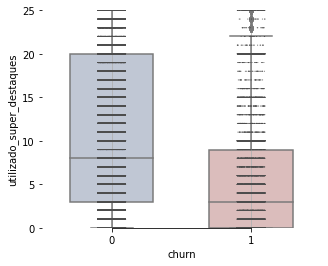

In [1926]:
box_plot("utilizado_super_destaques", 0, 25)

### Análise Utilizado Destaque (pode influenciar o churn)

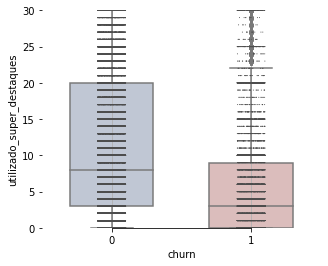

In [1927]:
box_plot("utilizado_super_destaques", 0, 30)

### Análise Utilizado Ofertas Simples (Relação forte com o churn)

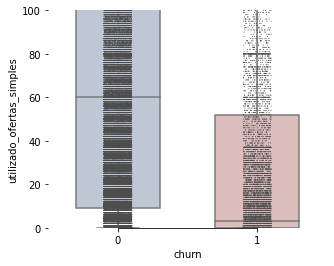

In [1928]:
box_plot("utilizado_ofertas_simples", 0, 100)

### Análise Leads Form (Relação forte com o churn)

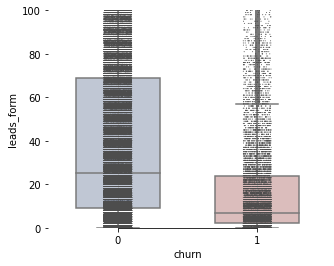

In [1929]:
box_plot("leads_form", 0, 100)

### Análise Leads Ver Dato (Relação forte com o churn)

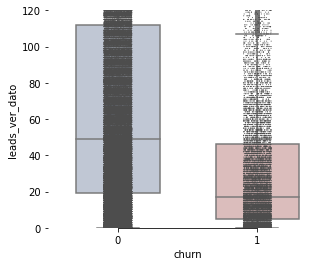

In [1930]:
box_plot("leads_ver_dato", 0, 120)

### Análise Leads Total (Relação forte com o churn)

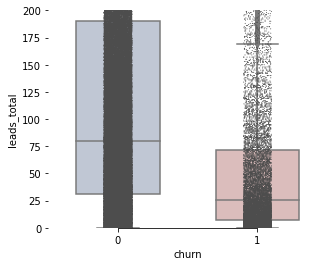

In [1931]:
box_plot("leads_total", 0, 200)

### Análise Custo Por Lead Total (Alta correlação com churn. Talvez seja melhor remover)

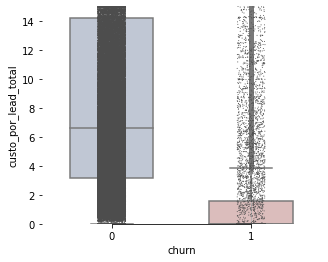

In [1932]:
box_plot("custo_por_lead_total", 0, 15)

### Análise Total Contratado (Relação fortíssima com o churn)

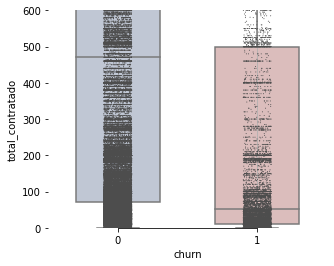

In [1933]:
box_plot("total_contratado", 0, 600)

### Análise Total de Listings (Relação forte com o churn)

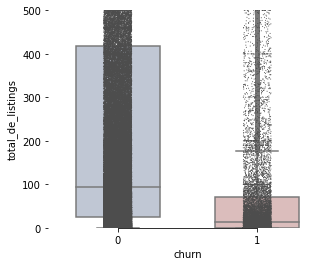

In [1934]:
box_plot("total_de_listings", 0, 500)

### Análise Custo Por Listing (Alta correlação com churn. Talvez seja melhor remover)

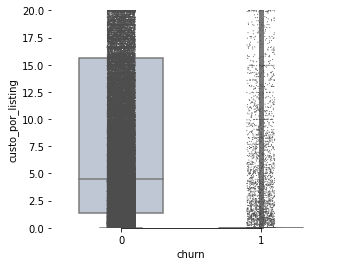

In [1935]:
box_plot("custo_por_listing", 0, 20)

### Análise Total Utilizado (Relação fortíssima com o churn)

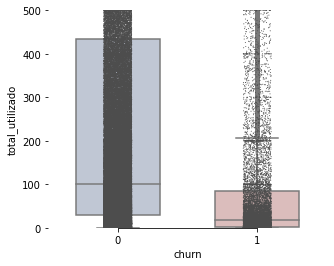

In [1936]:
box_plot("total_utilizado", 0, 500)

### Quantidade Mês (Relação fortíssima com o churn)

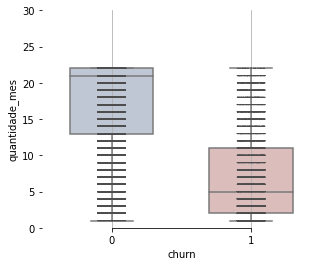

In [1937]:
box_plot("quantidade_mes", 0, 30)


# Data Cleaning and Data Wrangling

### Criação de novo dataframe com somente as colunas relevantes

In [1938]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado, quantidade_mes, status_pagamento

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [1939]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings',
         'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques',
         'utilizado_destaque', 'valor_mensal', 'quantidade_mes', 'status_pagamento', 'churn']].copy()


### Plot do gráfico de correlação entre variáveis preditoras

<AxesSubplot:>

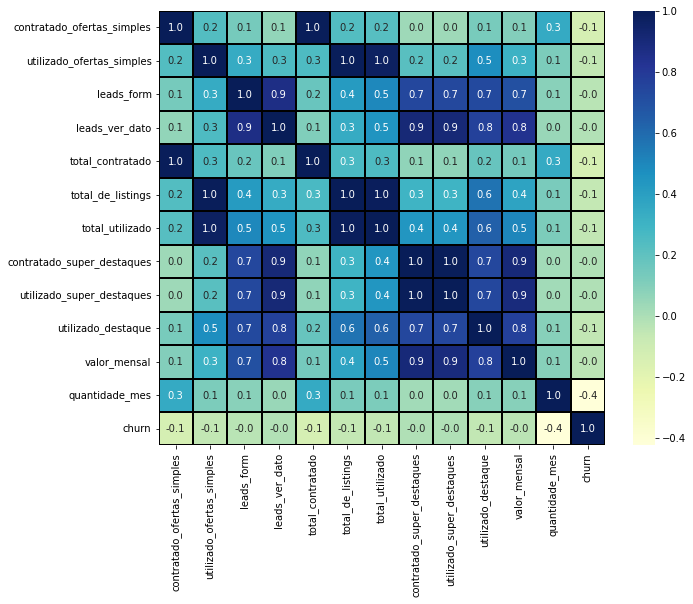

In [1940]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

# Modeling

### Isolar a variável de churn (target)

In [1941]:
dfChurn = df['churn']

### Tratamento das variáveis categóricas

#### Dumificação

In [1942]:
df.select_dtypes(include=['object'])


pf_pj       equipe status_pagamento
0         PJ  REGIONAL DF              NaN
1         PF  REGIONAL DF              NaN
2         PJ  REGIONAL DF              NaN
3         PJ  REGIONAL DF              NaN
4         PJ  REGIONAL DF              NaN
...      ...          ...              ...
149183    PJ  REGIONAL DF              NaN
149184    PJ  REGIONAL DF              NaN
149185    PF  REGIONAL DF              NaN
149186    PF  REGIONAL DF              NaN
149187    PF  REGIONAL DF              NaN

[149188 rows x 3 columns]

In [1943]:
df.select_dtypes(include=['object']).isna().sum()

pf_pj                    0
equipe                   0
status_pagamento    113850
dtype: int64

In [1944]:
df.dropna(subset=['status_pagamento'], inplace=True)


In [1945]:
df['status_pagamento'].isna().sum()


0

In [1946]:
dfCategorical = pd.get_dummies(df.select_dtypes(include=['object']), columns=[
                               'pf_pj', 'equipe', 'status_pagamento'])


In [1947]:
dfCategorical.head()

pf_pj_PF  pf_pj_PJ  equipe_JUMBO  equipe_REGIONAL DF  \
61209         0         1             1                   0   
61210         0         1             1                   0   
61211         0         1             1                   0   
61212         0         1             1                   0   
61213         0         1             1                   0   

       equipe_RELACIONAMENTO  equipe_RESELLERS  status_pagamento_Bom  \
61209                      0                 0                     0   
61210                      0                 0                     0   
61211                      0                 0                     0   
61212                      0                 0                     0   
61213                      0                 0                     0   

       status_pagamento_Novo  status_pagamento_Pessimo  \
61209                      0                         0   
61210                      0                         0   
61211                      0                         0   
61212                      0                         0   
61213                      0                         0   

       status_pagamento_Regular  status_pagamento_Ruim  
61209                         1                      0  
61210                         1                      0  
61211                         1                      0  
61212                         1                      0  
61213                         0                      1

### Tratamento das variáveis numéricas

In [1948]:
dfNumerical = df.select_dtypes(include=np.number).drop(['churn'], axis=1)


#### Tratamento de nulos (substituição por medianas)

In [1949]:
dfNumerical.isna().sum()


contratado_ofertas_simples      0
utilizado_ofertas_simples       0
leads_form                     28
leads_ver_dato                 30
total_contratado              228
total_de_listings               0
total_utilizado                 0
contratado_super_destaques      0
utilizado_super_destaques       0
utilizado_destaque              0
valor_mensal                    0
quantidade_mes                  0
dtype: int64

In [1950]:
dfNumerical = dfNumerical.fillna(dfNumerical.median())


In [1951]:
dfNumerical.isna().sum()


contratado_ofertas_simples    0
utilizado_ofertas_simples     0
leads_form                    0
leads_ver_dato                0
total_contratado              0
total_de_listings             0
total_utilizado               0
contratado_super_destaques    0
utilizado_super_destaques     0
utilizado_destaque            0
valor_mensal                  0
quantidade_mes                0
dtype: int64

#### Transformação de valores negativos para 0

In [1952]:
for col in dfNumerical.columns:
    df[col][dfNumerical[col] < 0] = 0

#### Tratamento de outliers e normalização dos dados

In [1953]:
dfNumerical = dfNumerical.copy()
dfNumerical[['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings', 'total_utilizado', 'contratado_super_destaques', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal']] = RobustScaler().fit_transform(dfNumerical[['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'leads_ver_dato',
                                                                                       'total_contratado', 'total_de_listings', 'total_utilizado', 'contratado_super_destaques', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal']])


### Concatenação das variáveis tratadas à variável target

In [1954]:
df = pd.concat([dfNumerical, dfCategorical, dfChurn], axis = 1, join='inner')

In [1955]:
df.head()


contratado_ofertas_simples  utilizado_ofertas_simples  leads_form  \
61209                    0.985647                  95.054348  514.714286   
61210                    0.985647                 174.007246   56.214286   
61211                    0.985647                   7.050725   86.750000   
61212                    0.584161                  13.148551    7.750000   
61213                    0.985647                  -0.166667    0.214286   

       leads_ver_dato  total_contratado  total_de_listings  total_utilizado  \
61209      819.714286          4.687531         193.296636       182.644509   
61210       89.095238          1.241850         154.822630       146.283237   
61211       43.428571          1.290801          14.363914        13.537572   
61212        5.488095          0.986057          23.492355        22.164740   
61213        0.190476          1.006119           0.085627         0.043353   

       contratado_super_destaques  utilizado_super_destaques  \
61209                 1646.470588                1646.588235   
61210                   37.647059                  37.470588   
61211                   53.588235                  51.705882   
61212                  208.235294                 207.176471   
61213                    2.941176                   2.882353   

       utilizado_destaque  ...  equipe_JUMBO  equipe_REGIONAL DF  \
61209          266.222222  ...             1                   0   
61210           58.311111  ...             1                   0   
61211           55.585185  ...             1                   0   
61212           15.851852  ...             1                   0   
61213            0.859259  ...             1                   0   

       equipe_RELACIONAMENTO  equipe_RESELLERS  status_pagamento_Bom  \
61209                      0                 0                     0   
61210                      0                 0                     0   
61211                      0                 0                     0   
61212                      0                 0                     0   
61213                      0                 0                     0   

       status_pagamento_Novo  status_pagamento_Pessimo  \
61209                      0                         0   
61210                      0                         0   
61211                      0                         0   
61212                      0                         0   
61213                      0                         0   

       status_pagamento_Regular  status_pagamento_Ruim  churn  
61209                         1                      0      0  
61210                         1                      0      0  
61211                         1                      0      0  
61212                         1                      0      0  
61213                         0                      1      0  

[5 rows x 24 columns]

### Testes com algorítmos executados manualmente

#### Divisão do dataset em treino e teste e validação

In [1956]:
X = df.drop(['churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns = X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#### Execução do modelo

In [1957]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'num_class': 3}

steps = 20  # The number of training iterations

modelXG = xgb.train(param, D_train, steps)

modelRF = RandomForestClassifier(n_jobs=-1)
modelRF.fit(X_train, y_train)

modelGB = GradientBoostingClassifier()
modelGB.fit(X_train, y_train)


GradientBoostingClassifier()

#### Resultados do modelo

In [1958]:
predictXG = modelXG.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in predictXG])

f1 = round(f1_score(y_test, best_preds, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, best_preds)*100, 2)
precision = round(precision_score(y_test, best_preds)*100, 2)
recall = round(recall_score(y_test, best_preds)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


F1 Score: 82.2%
Accuracy Score: 95.42%
Precision Score: 87.9%
Recall Score: 53.96%


F1 Score: 84.24%
Accuracy Score: 95.8%
Precision Score: 87.78%
Recall Score: 59.24%


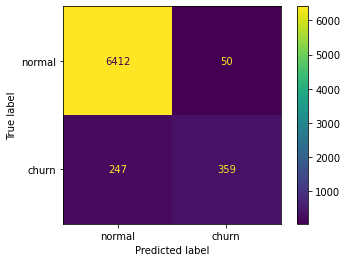

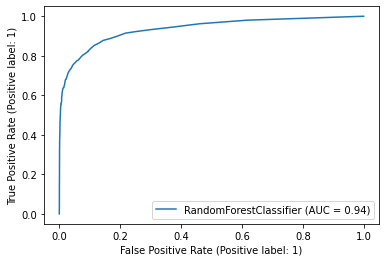

In [1959]:
predictRF = modelRF.predict(X_test)

f1 = round(f1_score(y_test, predictRF, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictRF)*100, 2)
precision = round(precision_score(y_test, predictRF)*100, 2)
recall = round(recall_score(y_test, predictRF)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_test, y_test)
plt.show()


F1 Score: 85.2%
Accuracy Score: 96.0%
Precision Score: 88.0%
Recall Score: 61.72%


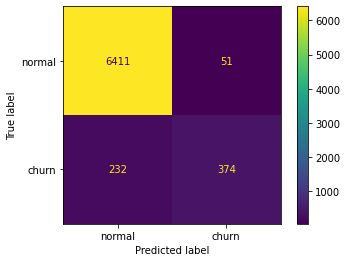

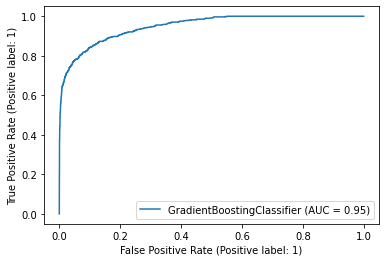

In [1960]:
predictGB = modelGB.predict(X_test)

f1 = round(f1_score(y_test, predictGB, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictGB)*100, 2)
precision = round(precision_score(y_test, predictGB)*100, 2)
recall = round(recall_score(y_test, predictGB)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_test, y_test)
plt.show()


In [1961]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


accuracy  precision  recall     f1
XGBoost              95.42      87.90   53.96  82.20
RandomForest         95.80      87.78   59.24  84.24
GradientBoosting     96.00      88.00   61.72  85.20

### Definição do melhor modelo

In [1962]:
clf = modelGB


### Tunning de hiperparâmetros dos melhores modelos

In [1963]:
# parameters = {
#     'learning_rate': [0.01, 0.02, 0.03],
#     'subsample': [0.9, 0.5, 0.2],
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [4, 6, 8]
# }

# bayes_search = BayesSearchCV(modelGB, search_spaces=parameters, cv=3, n_jobs=-1, verbose=10)
# bayes_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9
[CV 2/3; 1/1] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9
[CV 2/3; 1/1] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=0.950 total time=   6.7s
[CV 3/3; 1/1] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9
[CV 1/3; 1/1] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=0.952 total time=   6.8s
[CV 3/3; 1/1] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=0.951 total time=   5.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2
[CV 2/3; 1/1] START learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2
[CV 1/3; 1/1] END learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2;, score=0.960 total time= 

BayesSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
              search_spaces={'learning_rate': [0.01, 0.02, 0.03],
                             'max_depth': [4, 6, 8],
                             'n_estimators': [100, 500, 1000],
                             'subsample': [0.9, 0.5, 0.2]},
              verbose=10)

In [1964]:
# bayes_search.best_estimator_
# GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9)


GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=1000,
                           subsample=0.9)

F1 Score: 86.03%
Accuracy Score: 96.15%
Precision Score: 87.44%
Recall Score: 64.36%


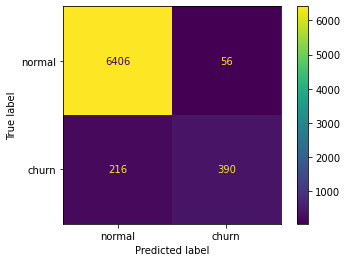

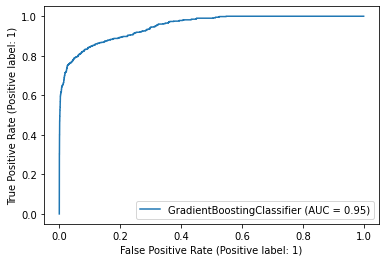

In [1975]:
clf = GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.9)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(clf, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
                      
plt.grid(False)
plt.show()

plot_roc_curve(clf, X_test, y_test)
plt.show()


In [1976]:
joblib.dump(clf, 'GB_churn_imovel_web.pkl')


['GB_churn_imovel_web.pkl']

### Avaliação da performance do modelo com os dados de validação

In [1985]:
y_pred = clf.predict(X_val)

data_set_valid = X_val.reset_index(drop=True)
y_real = pd.Series(y_val).reset_index(drop=True)
y_predito = pd.Series(y_pred, name='churn_predito').reset_index(drop=True)

df_valid = pd.concat([data_set_valid, y_real, y_predito], axis=1)

Quantidade total: 7068
Preditos Corretamente: 6790
Preditos Icorretamente: 278


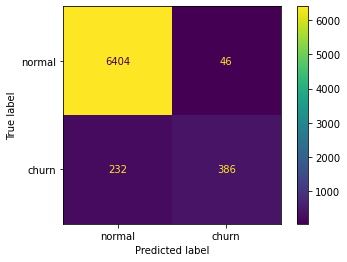

In [1986]:
print('Quantidade total: {}'.format(len(df_valid)))
print('Preditos Corretamente: {}'.format(len(df_valid[df_valid['churn'] == df_valid['churn_predito']])))
print('Preditos Icorretamente: {}'.format(len(df_valid[df_valid['churn'] != df_valid['churn_predito']])))


plot_confusion_matrix(clf, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")


### Interpretabilidade individual do resultado dos registros classificados pelo modelo

In [1987]:
def predict_explainer(df_fil):
    ''' Apresenta o explain das probabilidades que definiram o registro como "churn" ou não '''
    index_registro_visualizacao = df_fil.sample().index[0]

    print('Quantidade de registros preditos nessa categoria: {}'.format(len(df_fil)))
    print()
    print('-' * 5 + ' Churn Real / Churn Predito ' + '-' * 5)
    print()
    print(df_valid[['churn', 'churn_predito']
                   ].iloc[index_registro_visualizacao])
    print()
    print('-' * 5 + ' Probabilidade ' + '-' * 5)

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=[
                                                       "Não Churn", "Churn"],
                                                   mode='classification')

    exp = explainer.explain_instance(X_val.iloc[index_registro_visualizacao],
                                     clf.predict_proba,
                                     num_features=10,
                                     top_labels=1)

    return exp.show_in_notebook(show_table=True, show_all=False)


In [1988]:
# Reseta os índices para que possamos procurar os registros

X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


#### Explain aleatório dos "Churns" considerados "Churn" pelo modelo

In [1989]:
df_fil = df_valid[(df_valid['churn'] == df_valid['churn_predito']) & (df_valid['churn'] == 1)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 386

----- Churn Real / Churn Predito -----

churn            1
churn_predito    1
Name: 2655, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churns" considerados "Não Churn" pelo modelo

In [1990]:
df_fil = df_valid[(df_valid['churn'] == df_valid['churn_predito']) & (df_valid['churn'] == 0)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 6404

----- Churn Real / Churn Predito -----

churn            0
churn_predito    0
Name: 3707, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Churns" considerados "Não Churn"

In [1991]:
df_fil = df_valid[(df_valid['churn'] != df_valid['churn_predito']) & (df_valid['churn'] == 1)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 232

----- Churn Real / Churn Predito -----

churn            1
churn_predito    0
Name: 3223, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churn" considerados "Churn"

In [1992]:
df_fil = df_valid[(df_valid['churn'] != df_valid['churn_predito']) & (df_valid['churn'] == 0)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 46

----- Churn Real / Churn Predito -----

churn            0
churn_predito    1
Name: 1711, dtype: int64

----- Probabilidade -----
